In [1]:
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse as sp

%matplotlib inline

In [2]:
def get_relationships(graph_file):
    
    # Read graph file into graph object
    G_ = nx.read_gml(graph_file, label='id')
    
    # Important for non-relational GCNs
    G = make_undirected(G_)
    H = remove_isolated_nodes(G)
    
    # Create space between nodes for clearer displaying
    fig, ax = plt.subplots(1)
#     pos = nx.spring_layout(G,k=0.3,iterations=20)
#     nx.draw(G, pos, ax=ax, with_labels=True)

    # Get nodes geological names instead of ids
    labels = nx.get_node_attributes(G, 'LabelGraphics')
    labels = [lab['text'] for lab in labels.values()]
    # Map old numeric labels to new descriptive ones to use as a figure legend
    old2name = dict(zip(G.nodes, labels))
    new_ids = list(range(len(G.nodes)))
    name2new = dict(zip(labels, new_ids))
    old2new = dict(zip(G.nodes, new_ids))
    
    # Replace node labels with new ids 
    H = nx.relabel_nodes(G, old2new)
    pos = nx.spring_layout(H,k=0.3,iterations=20)
    nx.draw(H, pos, ax=ax, with_labels=True)
    print(list(zip(new_ids, labels)))

    
#     # Format figure and add legend
#     legend_text = "\n".join(f"{v} - {k}" for k, v in old_name2num.items())
#     props = dict(boxstyle="round", facecolor="w", alpha=0.5)
#     ax.text(
#         1.15,
#         0.95,
#         legend_text,
#         transform=ax.transAxes,
#         fontsize=14,
#         verticalalignment="top",
#         bbox=props,
#     )
                    
    plt.show()
    
    print("Nodes: ", len(H))
    S = nx.to_pandas_adjacency(H).values
    return  H, S, old2name, old2new

def make_undirected(G):
    graph_dict = nx.to_dict_of_lists(G)

    for node in graph_dict.keys():
        neighbours = graph_dict[node]
        for n in neighbours:
            if node not in graph_dict[n]:
                G.add_edge(n, node)

    return G

def remove_isolated_nodes(G):
    graph_dict = nx.to_dict_of_lists(G)

    for node in graph_dict.keys():
        if len(graph_dict[node]) < 1:
            # Pick off nodes with no neighbours
            G.remove_node(node)
    
    return G

[(0, 'Ashburton Formation'), (1, 'Beasley River Quartzite'), (2, 'Bellary Formation'), (3, 'Boolgeeda Iron Formation'), (4, 'Boongal Formation'), (5, 'Brockman Iron Formation'), (6, 'Bunjinah Formation'), (7, 'Cheela Springs Basalt'), (8, 'Duck Creek Dolomite'), (9, 'Fortescue Group'), (10, 'Hardey Formation'), (11, 'Jeerinah Formation'), (12, 'Kungarra Formation'), (13, 'Marra Mamba Iron Formation'), (14, 'Milli Milli Inlier greenstones'), (15, 'Milli Milli Inlier metagranitc unit'), (16, 'Mount McGrath Formation'), (17, 'Mount McRae Shale and Mount Sylvia Formation'), (18, 'Mount Roe Basalt'), (19, 'Pyradie Formation'), (20, 'Rocklea Inlier greenstones'), (21, 'Rocklea Inlier metagranitic unit'), (22, 'Turee Creek Group'), (23, 'Weeli Wolli Formation'), (24, 'Wittenoom Formation'), (25, 'Woongarra Rhyolite')]


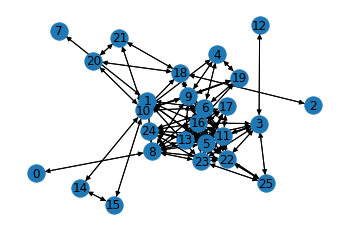

Nodes:  26


In [3]:
graph_file = "./wa-part/graph/graph_all_NONE.gml"

G, S, old2name, old2new = get_relationships(graph_file)

In [4]:
adj = nx.adjacency_matrix(G)

In [5]:
geol = gpd.read_file('./wa-part/tmp/geol_clip.shp')
geol_vec = geol[['code', 'unitname', 'formation', 'rocktype1', 'lithname1', 'min_age_ma', 'max_age_ma', 'supergroup']]

# for name in old2name.values():
#     print(name)
features_ = []
for unit_name in old2name.values():
    df = geol_vec[geol_vec['unitname'] == unit_name]
    modes = df.mode()

    min_age = 0
    max_age = 0
    try:
        min_age = float(modes['min_age_ma'].to_numpy()[0]) 
        max_age = float(modes['max_age_ma'].to_numpy()[0])
    except Exception as e:
        print("WARNING: There are missing age ranges in this area. Unitname -> ", unit_name)
        
    features_.append([min_age, max_age])
    
features_ = np.array(features_)
features = sp.lil_matrix(features_)

In [6]:
print(adj.shape)
print(features.shape)

(26, 26)


In [8]:
graph_dict = nx.to_dict_of_lists(G)
graph_dict

{0: [8],
 1: [6, 5, 22, 23, 7, 8, 16],
 2: [18],
 3: [25, 23, 11, 13, 5, 12, 16, 22],
 4: [10, 6, 9, 19],
 5: [13, 6, 24, 17, 11, 9, 1, 3, 8, 16, 23, 25],
 6: [10, 19, 4, 1, 5, 8, 9, 11, 13, 16, 22],
 7: [1],
 8: [6, 1, 5, 23, 9, 16, 22, 11, 13, 0],
 9: [18, 10, 6, 4, 19, 5, 8, 11, 13, 16],
 10: [18, 14, 15, 20, 21, 4, 6, 9, 19],
 11: [6, 9, 3, 5, 8, 13, 16, 17, 22, 23, 24],
 12: [3],
 13: [6, 11, 9, 3, 5, 8, 16, 17, 24],
 14: [10, 15],
 15: [14, 10],
 16: [6, 3, 19, 11, 5, 23, 17, 9, 1, 22, 24, 13, 8],
 17: [13, 24, 11, 5, 16, 23],
 18: [20, 21, 2, 9, 10],
 19: [10, 4, 6, 9, 16],
 20: [10, 18, 21],
 21: [20, 10, 18],
 22: [25, 6, 3, 23, 11, 1, 8, 16],
 23: [5, 17, 24, 11, 1, 3, 8, 16, 22, 25],
 24: [13, 11, 5, 16, 17, 23],
 25: [23, 5, 3, 22]}